# Load Keras CKA files

In [2]:
#-----------------------------------------------------------------------------------------------------------------
FILEID = "1DOm75xoSPUbnFfcJBjVggPS0hzNEoWCG"
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id='$FILEID -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id="$FILEID -O MIfunctions.py && rm -rf /tmp/cookies.txt
#-----------------------------------------------------------------------------------------------------------------

#-----------------------------------------------------------------------------------------------------------------
FILEID = "10HTvdBUnBZWn8HuPBzVxFlLDgkBqEnjR"
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id='$FILEID -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id="$FILEID -O giga_W_Y.mat && rm -rf /tmp/cookies.txt
#-----------------------------------------------------------------------------------------------------------------


--2021-03-01 18:12:01--  https://docs.google.com/uc?export=download&confirm=&id=1DOm75xoSPUbnFfcJBjVggPS0hzNEoWCG
Resolving docs.google.com (docs.google.com)... 108.177.97.113, 108.177.97.100, 108.177.97.102, ...
Connecting to docs.google.com (docs.google.com)|108.177.97.113|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-00-8c-docs.googleusercontent.com/docs/securesc/lhsljketd6ia1j5ak9go3hpqdjfh1i3l/0a16ld06383r8bk21jbgt8eqd053tjvn/1614622275000/06932581800131476027/07144167849627109067Z/1DOm75xoSPUbnFfcJBjVggPS0hzNEoWCG?e=download [following]
--2021-03-01 18:12:02--  https://doc-00-8c-docs.googleusercontent.com/docs/securesc/lhsljketd6ia1j5ak9go3hpqdjfh1i3l/0a16ld06383r8bk21jbgt8eqd053tjvn/1614622275000/06932581800131476027/07144167849627109067Z/1DOm75xoSPUbnFfcJBjVggPS0hzNEoWCG?e=download
Resolving doc-00-8c-docs.googleusercontent.com (doc-00-8c-docs.googleusercontent.com)... 74.125.23.132, 2404:6800:4008:c02::84
Connecting to d

# Load data for all subjects Giga collection

# Import supporting modules

In [3]:
#-----------------------------------------------------------------------------------------------------------------
import pickle
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_probability as tfp
from sklearn.model_selection import KFold
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import pdist, squareform
from sklearn.utils import shuffle
import tensorflow as tf
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.decomposition import KernelPCA
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics.pairwise import euclidean_distances
#-----------------------------------------------------------------------------------------------------------------

# Concatenating subjects data (Feature mappings)

In [4]:
import scipy.io as sio
import numpy as np
#data = sio.loadmat('../input/datos-conectividad-acc/data_ccx_acc.mat')
data = sio.loadmat('giga_W_Y.mat')
XT = data['W']
YT = data['Y']#.reshape((-1))
acc = YT
# dat  = sio.loadmat('acc2.mat')
# acc = dat['Y']

# Pedirle a daniel el mejor vector de acierto por sujetos para csp, algunos de los acc estan por debajo de 50 y eso no tiene sentido

# Data normalization

X normalized dimensions: (50, 4032) 1.0 0.0


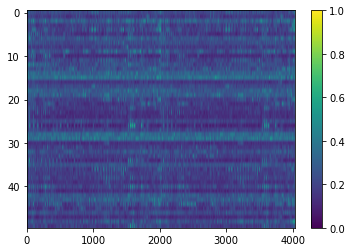

In [5]:
#----------------------------------------------------------------------------------------------------------------
# for each sample (row) we apply min-max transformation
XT_norm = np.zeros((XT.shape))
for k in range(XT.shape[0]):
  XT_norm[k,:] = (XT[k,:]-XT[k,:].min())/(XT[k,:].max()-XT[k,:].min())
print('X normalized dimensions:',XT_norm.shape,XT_norm.max(),XT_norm.min())
#----------------------------------------------------------------------------------------------------------------
# plot resulting matrix
plt.imshow(XT_norm,aspect='auto')
plt.colorbar()
plt.show()
#----------------------------------------------------------------------------------------------------------------
del XT

In [6]:
#scaler=MinMaxScaler()
#YT = scaler.fit_transform(YT)
print(YT)

[[0.2705314 ]
 [0.12560386]
 [0.95652174]
 [0.85024155]
 [0.58937198]
 [0.53681159]
 [0.12077295]
 [0.        ]
 [0.15304348]
 [0.73913043]
 [0.08695652]
 [0.31884058]
 [0.51690821]
 [0.97584541]
 [0.42975845]
 [0.15942029]
 [0.12077295]
 [0.14009662]
 [0.22821256]
 [0.33256039]
 [0.37681159]
 [0.34299517]
 [0.9178744 ]
 [0.12560386]
 [0.39613527]
 [0.62318841]
 [0.16850242]
 [0.33816425]
 [0.13333333]
 [0.43478261]
 [0.06763285]
 [0.16425121]
 [0.50241546]
 [0.39516908]
 [0.44927536]
 [0.18705314]
 [0.33816425]
 [0.02898551]
 [0.96135266]
 [0.14492754]
 [1.        ]
 [0.58937198]
 [0.11594203]
 [0.69236715]
 [0.26628019]
 [0.81642512]
 [0.54879227]
 [0.76328502]
 [0.02357488]
 [0.28502415]]


# CKA sobre CNN features (normalizadas)

In [7]:
# -*- coding: utf-8 -*-
import tensorflow as tf
import matplotlib.pyplot as plt
#from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
import tensorflow_probability as tfp
from sklearn.decomposition import PCA
from tensorflow.keras import regularizers
from sklearn.base import  BaseEstimator, TransformerMixin, ClassifierMixin
from sklearn.model_selection import train_test_split
tf.keras.backend.clear_session()
tf.random.set_seed(42)
import types
import tempfile
class Keras_CKA2(BaseEstimator, TransformerMixin):
	def __init__(self,epochs=200,batch_size=30,Q=0.9,learning_rate=1e-3,optimizer='Adam',
		  l1_param=0,l2_param=0,validation_split=0.2,gamma=1.0,verbose=1,init_='def_keras',gamma_y=1e-13):
		self.epochs = epochs
		self.gamma = gamma
		self.gamma_y = gamma_y
		self.batch_size = batch_size
		self.learning_rate=learning_rate 
		self.l1_param=l1_param 
		self.l2_param=l2_param
		self.validation_split = validation_split
		self.verbose = verbose
		self.optimizer = optimizer
		self.Q=Q
		self.init_=init_
  	# Define custom loss
	def custom_cka_loss(self,y_true,y_pred): #ytrue labels, ypred  = Xw
		####gradiente##########################################
		scalar_kernel = tfp.math.psd_kernels.ExponentiatedQuadratic(amplitude=1, length_scale=tf.constant(self.gamma,dtype=tf.float32))
		scalar_kernely = tfp.math.psd_kernels.ExponentiatedQuadratic(amplitude=1, length_scale=tf.constant(self.gamma_y,dtype=tf.float32))
		k = scalar_kernel.matrix(y_pred, y_pred)
		l = scalar_kernely.matrix(y_true, y_true)
		######################################################
		N = tf.shape(l)[0]
		N2 = tf.cast(tf.shape(l)[0],dtype=tf.float32)
		h = tf.eye(N) - (1.0/N2)*tf.ones([N,1])*tf.ones([1,N]) #matrix for centered kernel
		trkl = tf.linalg.trace(tf.matmul(tf.matmul(k,h),tf.matmul(l,h)))
		trkk = tf.linalg.trace(tf.matmul(tf.matmul(k,h),tf.matmul(k,h)))
		trll = tf.linalg.trace(tf.matmul(tf.matmul(l,h),tf.matmul(l,h)))
		#####funcion de costo############################################3
		f     = -trkl/tf.sqrt(trkk*trll)# negative cka cost function (minimizing) f \in [-1,0]
		return f
	def fit(self,X,Y):
		#input X numpy array first dimension Trials x features1 x features2.
		#input Y numpy array vector len = Trials.
		if self.optimizer == "Adam":
			opt = tf.keras.optimizers.Adam(learning_rate=self.learning_rate)
		elif self.optimizer == "SGD":
			opt = tf.keras.optimizers.SGD(learning_rate=self.learning_rate)
		else:
			opt=self.optimizer
		# split train and test
		X_train, y_train = X,Y #, X_test, y_train, y_test = train_test_split(X, Y, test_size=self.validation_split, random_state=0)
		if self.init_ == 'pca':
			pca_2 = PCA(n_components=self.Q, random_state = 0)
			pca_2.fit(X_train.reshape((X_train.shape[0],-1)))
			self.init_ = pca_2.components_.T
			self.Q = pca_2.n_components_
		else:
			if self.Q<1:
				pca_1 = PCA(n_components=self.Q, random_state = 0)
				pca_1.fit(X_train.reshape((X_train.shape[0],-1)))
				self.Q = pca_1.n_components_
		if len(tf.shape(X_train))>2:
			input_layer = tf.keras.layers.Input(shape=[X_train.shape[1],X_train.shape[2]])
			flatten_layer = tf.keras.layers.Flatten(input_shape=(X_train.shape[1],X_train.shape[2]))(input_layer)
			if self.init_ == 'def_keras':
				output_layer = tf.keras.layers.Dense(self.Q, activation="linear", 
					kernel_regularizer=regularizers.l1_l2(l1=self.l1_param, l2=self.l2_param), 
					use_bias=False, kernel_initializer=tf.keras.initializers.GlorotNormal(seed=0), name= 'Proj')(flatten_layer)
			else:
				output_layer = tf.keras.layers.Dense(self.Q, activation="linear", 
					kernel_regularizer=regularizers.l1_l2(l1=self.l1_param, l2=self.l2_param),
					use_bias=False, weights=[self.init_], name= 'Proj')(flatten_layer)
		else:
			input_layer = tf.keras.layers.Input(shape = [X_train.shape[1]])
			if self.init_ == 'def_keras':
				output_layer = tf.keras.layers.Dense(self.Q, activation="linear", 
					kernel_regularizer=regularizers.l1_l2(l1=self.l1_param, l2=self.l2_param), 
					use_bias=False, kernel_initializer=tf.keras.initializers.GlorotNormal(seed=0), name= 'Proj')(input_layer)
			else:
				output_layer = tf.keras.layers.Dense(self.Q, activation="linear", 
					kernel_regularizer=regularizers.l1_l2(l1=self.l1_param, l2=self.l2_param),
					use_bias=False, weights=[self.init_], name= 'Proj')(input_layer)
		self.model = tf.keras.Model(inputs=input_layer,outputs=output_layer)
		self.model.compile(loss=self.custom_cka_loss, optimizer=opt)
		keys = [weight.name for layer in self.model.layers for weight in layer.weights]
		weights_in = self.model.get_weights()
		self.A_in = {}
		for key, weight in zip(keys, weights_in):
			self.A_in[key] = weight 
#		self.history = self.model.fit(X_train, y_train, epochs=self.epochs,
#					validation_data=(X_test, y_test),batch_size=self.batch_size,
#										verbose=self.verbose)
		self.history = self.model.fit(X_train, y_train, epochs=self.epochs,
					validation_split=0,batch_size=self.batch_size,
										verbose=self.verbose)

		weights_out = self.model.get_weights()
		self.A_out = {}
		for key, weight in zip(keys, weights_out):
			self.A_out[key] = weight
		return self
	def transform(self, X, *_):
		Xr = self.model.predict(X)
		return  Xr
	def fit_transform(self,X,y):
		self.fit(X,y)
		return  self.transform(X)
	def plot_history(self):
		plt.plot(self.history.history['loss'],label='loss')
		plt.plot(self.history.history['val_loss'],label='val_loss')
		plt.legend()
		return
	def __getstate__(self):
		model_str = ""
		with tempfile.NamedTemporaryFile(suffix='.h5', delete=True) as fd:
			try:
				self.model.save(fd.name,save_format='h5')
				model_str = fd.read()
			except:
				model_str='model no trained'
				self.A_out='model no trained'
				self.A_in='model no trained'
		d = { 'model_str': model_str,
		'A_in':self.A_in,
		'A_out':self.A_out,
		'gamma':self.gamma,
		'gamma_y':self.gamma_y,
		'epochs':self.epochs,
		'batch_size':self.batch_size,
		'learning_rate':self.learning_rate,
		'l1_param':self.l1_param,
		'l2_param':self.l2_param,
		'validation_split':self.validation_split,
		'verbose':self.verbose,
		'optimizer':self.optimizer,
		'Q':self.Q,
		'init_':self.init_}
		return d
	def __setstate__(self, state):
		self.gamma=state['gamma']
		self.gamma_y=state['gamma_y']
		self.epochs=state['epochs']
		self.batch_size=state['batch_size']
		self.learning_rate=state['learning_rate']
		self.l1_param=state['l1_param']
		self.l2_param=state['l2_param']
		self.validation_split=state['validation_split']
		self.verbose=state['verbose']
		self.optimizer=state['optimizer']
		self.Q=state['Q']
		self.init_=state['init_']
		with tempfile.NamedTemporaryFile(suffix='.h5', delete=True) as fd:
			try:
				fd.write(state['model_str'])
				fd.flush()
				self.model = tf.keras.models.load_model(fd.name,custom_objects={'custom_cka_loss': self.custom_cka_loss})	
				self.A_in=state['A_in']
				self.A_out=state['A_out']
			except:
				self.mode=state['model_str']
				#print(state['model_str'])

In [8]:
#----------------------------------------------------------------------------------------------------------------
# estimating average gamma_y value using 10 subsets
skf     = KFold(n_splits=10, shuffle=True, random_state=123)
#----------------------------------------------------------------------------------------------------------------
gamma_y = []
for train_index, valid_index in skf.split(YT):
  dd = pairwise_distances(YT[valid_index],YT[valid_index])
  d  = 0.5*(dd+dd.T) 
  d  = d-np.diag(np.diag(d))  
  gamma_y.append(np.median(squareform(d)))
gamma_y_YT = np.median(np.array(gamma_y))
print('Average gamma_y using probs:',gamma_y_YT)
#----------------------------------------------------------------------------------------------------------------
del dd,d

Average gamma_y using probs: 0.2846859903381643


ytf_YT dimensions: (50, 1)
kernel dimensions YTQ: (50, 50)


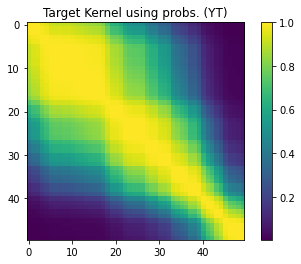

In [9]:
#----------------------------------------------------------------------------------------------------------------
# computing kernel target and show
gamma_y_YT = np.float32(gamma_y_YT)
#----------------------------------------------------------------------------------------------------------------
# convert to tensor
ytf_YT = tf.convert_to_tensor(YT,dtype=tf.float32)
print('ytf_YT dimensions:',ytf_YT.shape)
#----------------------------------------------------------------------------------------------------------------
# define kernel
scalar_kernely_YT = tfp.math.psd_kernels.ExponentiatedQuadratic(amplitude=1, length_scale=gamma_y_YT)
l_YT              = scalar_kernely_YT.matrix(ytf_YT, ytf_YT)
print('kernel dimensions YTQ:',l_YT.shape)
#----------------------------------------------------------------------------------------------------------------
# ordering data
ind_YT = np.argsort(YT[:,0])
l_YT   = l_YT.numpy()[ind_YT]
l_YT   = l_YT[:,ind_YT]
#-----------------------------------------------------------------------------------------------------------------
# print kernels
plt.figure()
plt.imshow(l_YT)
plt.colorbar()
plt.title('Target Kernel using probs. (YT)')
plt.show()
#-----------------------------------------------------------------------------------------------------------------

In [10]:
print(np.arange(50))

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]


# CKA using Probs as Ky

In [11]:
#-----------------------------------------------------------------------------------------------------------------
# define cka parameters
epochs           = 150
batch_size       = 256
learning_rate    = 1e-3
l1               = 1e-3
l2               = l1
validation_split = 0
verbose          = 50
Q                = 0.9 # num of subjects to fix dimensions
#-----------------------------------------------------------------------------------------------------------------
# define cka
redcka           = Keras_CKA2(epochs=epochs,batch_size=batch_size,Q=Q,learning_rate=learning_rate,
                              l1_param=l1,l2_param=l2,validation_split=validation_split,verbose=verbose,gamma_y=gamma_y_YT)
#-----------------------------------------------------------------------------------------------------------------
# apply cka to data
redcka.fit_transform(XT_norm,YT.astype('float64'))
#-----------------------------------------------------------------------------------------------------------------

Epoch 1/150
Epoch 2/150
Epoch 3/150
Epoch 4/150
Epoch 5/150
Epoch 6/150
Epoch 7/150
Epoch 8/150
Epoch 9/150
Epoch 10/150
Epoch 11/150
Epoch 12/150
Epoch 13/150
Epoch 14/150
Epoch 15/150
Epoch 16/150
Epoch 17/150
Epoch 18/150
Epoch 19/150
Epoch 20/150
Epoch 21/150
Epoch 22/150
Epoch 23/150
Epoch 24/150
Epoch 25/150
Epoch 26/150
Epoch 27/150
Epoch 28/150
Epoch 29/150
Epoch 30/150
Epoch 31/150
Epoch 32/150
Epoch 33/150
Epoch 34/150
Epoch 35/150
Epoch 36/150
Epoch 37/150
Epoch 38/150
Epoch 39/150
Epoch 40/150
Epoch 41/150
Epoch 42/150
Epoch 43/150
Epoch 44/150
Epoch 45/150
Epoch 46/150
Epoch 47/150
Epoch 48/150
Epoch 49/150
Epoch 50/150
Epoch 51/150
Epoch 52/150
Epoch 53/150
Epoch 54/150
Epoch 55/150
Epoch 56/150
Epoch 57/150
Epoch 58/150
Epoch 59/150
Epoch 60/150
Epoch 61/150
Epoch 62/150
Epoch 63/150
Epoch 64/150
Epoch 65/150
Epoch 66/150
Epoch 67/150
Epoch 68/150
Epoch 69/150
Epoch 70/150
Epoch 71/150
Epoch 72/150
Epoch 73/150
Epoch 74/150
Epoch 75/150
Epoch 76/150
Epoch 77/150
Epoch 78

array([[-9.3530826e-03,  2.9783346e-02, -2.8096370e-02, ...,
         2.6860645e-03,  4.1958646e-04,  2.0304851e-02],
       [-1.1397772e-02,  5.3007230e-03, -2.1889351e-02, ...,
         1.2206454e-03, -3.0116679e-04, -9.2129350e-02],
       [-3.3342582e-04,  1.9633314e-01, -3.8725466e-02, ...,
         5.6897104e-03,  1.7561801e-03, -3.4274322e-01],
       ...,
       [-3.6489526e-03,  8.4074005e-02, -1.8018164e-02, ...,
         1.1322702e-03,  9.2480588e-04, -1.6639131e-01],
       [-1.4107267e-02,  2.8832905e-02, -2.8966237e-02, ...,
         2.3845092e-03,  6.2503206e-04, -1.3841379e-01],
       [-4.9825190e-03,  2.4089888e-02, -2.3866698e-02, ...,
         1.2912479e-03,  1.7037216e-04,  2.2387717e-02]], dtype=float32)

In [12]:
#----------------------------------------------------------------------------------------------------------------
# apply cka to data
zxtt  = redcka.transform(XT_norm)
zxtt2 = TSNE(n_components=2,perplexity=10,init='pca').fit_transform(zxtt)
#---------------------------------------------------------------------------------------------------------------
# computing rho (relevance feature vector)
rho   = abs(redcka.A_out['Proj/kernel:0']).sum(axis=1)
rho   -= min(rho)
rho   /=max(rho)
print('rho dimension:',rho.shape)
print('A dimension:',redcka.A_out['Proj/kernel:0'].shape)
#---------------------------------------------------------------------------------------------------------------

rho dimension: (4032,)
A dimension: (4032, 37)


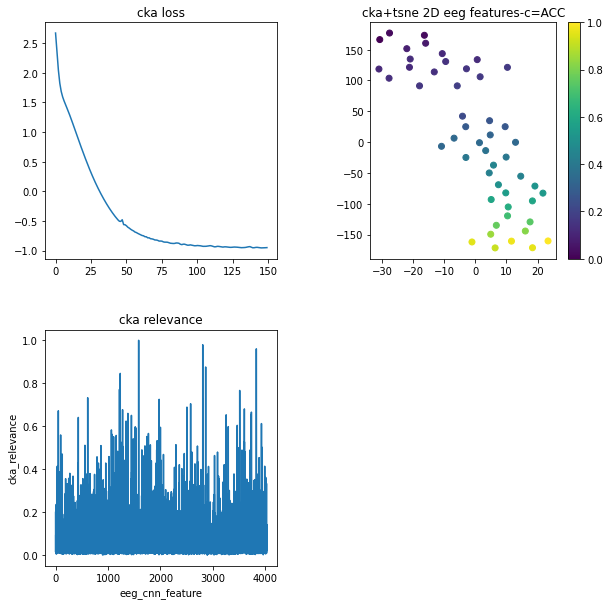

In [13]:
#----------------------------------------------------------------------------------------------------------------
# plotting results
plt.figure(figsize=(10,10))
# cka performance
plt.subplot(221)
plt.plot(redcka.history.history['loss'])
plt.title('cka loss')
# projected cka in pca 2d using probs as color
plt.subplot(222)
plt.scatter(zxtt2[:,0],zxtt2[:,1],c=acc)
plt.colorbar()
plt.title('cka+tsne 2D eeg features-c=ACC')
# relevance vector rho
plt.subplot(223)
plt.plot(rho)
plt.xlabel('eeg_cnn_feature')
plt.ylabel('cka_relevance')
plt.title('cka relevance')
# projected cka in pca 2d using id subjects as color

plt.subplots_adjust(hspace=0.3,wspace=0.4)
plt.show()
#----------------------------------------------------------------------------------------------------------------

In [14]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
# grupos 
num_clusters = np.arange(2,7) # número de grupos: de 2 a 6 grupos.
km = list()
for num in num_clusters:
  kmeans = KMeans(n_clusters=num, random_state=0).fit(zxtt2)
  km.append(kmeans.labels_)
km

[array([0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1,
        1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1,
        0, 1, 1, 1, 0, 0], dtype=int32),
 array([0, 2, 1, 1, 1, 1, 2, 2, 2, 1, 2, 0, 1, 1, 0, 2, 2, 2, 0, 0, 0, 0,
        1, 2, 0, 1, 2, 0, 2, 0, 2, 2, 1, 0, 0, 2, 0, 2, 1, 2, 1, 1, 2, 1,
        0, 1, 1, 1, 2, 0], dtype=int32),
 array([0, 2, 1, 1, 3, 3, 2, 2, 2, 1, 2, 0, 3, 1, 3, 2, 2, 2, 0, 0, 0, 0,
        1, 2, 0, 3, 2, 0, 2, 3, 2, 2, 3, 0, 3, 2, 0, 2, 1, 2, 1, 3, 2, 1,
        0, 1, 3, 1, 2, 0], dtype=int32),
 array([2, 1, 0, 0, 3, 3, 1, 4, 1, 0, 4, 2, 3, 0, 3, 1, 4, 1, 2, 2, 2, 2,
        0, 1, 2, 3, 1, 2, 1, 3, 4, 1, 3, 2, 3, 1, 2, 4, 0, 1, 0, 3, 1, 0,
        2, 0, 3, 0, 4, 2], dtype=int32),
 array([0, 4, 1, 1, 3, 3, 4, 2, 4, 1, 2, 0, 3, 1, 5, 4, 2, 4, 0, 0, 5, 0,
        1, 4, 5, 3, 4, 0, 4, 5, 2, 4, 3, 5, 5, 4, 0, 2, 1, 4, 1, 3, 4, 3,
        0, 1, 3, 1, 2, 0], dtype=int32)]

1. Correr kmeans sobre espacio proyectado de tsne buscando numero de grupos segun estrategia de silueta






In [15]:
# verificamos el número de grupos según silhouette
score = list()
for num in range(len(km)):
  score.append(silhouette_score(zxtt2, km[num]))
score

[0.61900187, 0.64126855, 0.6276037, 0.5464489, 0.50030196]


2. segun los grupos formados con kmeans buscar el rho promedio de cada grupo desde el vector rho calculado


In [16]:
pos_s = np.argmax(score) # valor donde silhouette es mayor.
tempora = XT_norm*rho
minn = MinMaxScaler()
temporal1= minn.fit_transform(tempora)
rho_gr = list()
for gr in range(0,3):
  rho_gr.append(np.mean(temporal1[km[pos_s]==gr,:],axis=0)) # me queda la dimentción de Cx por bandas.

Text(0.5, 1.0, 'cka+tsne 2D eeg features-c=ACC + Kmeans')

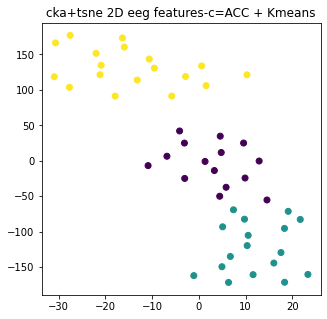

In [17]:
# Graficas los grupos de tsne
plt.figure(figsize=(5,5))
plt.scatter(zxtt2[:,0],zxtt2[:,1],c=km[pos_s])
plt.title('cka+tsne 2D eeg features-c=ACC + Kmeans')

In [18]:
from scipy.spatial.distance import squareform
rho_fr_= []
rho_fr = list()
min_   = list()
max_   = list()
for gr in range(len(rho_gr)):
  rho_fra = list()
  for fr in range(0,2):
    if fr == 0:
      temm = rho_gr[gr][0:2016]
    elif fr == 1:
      temm = rho_gr[gr][2016:4032]
    aa = sum(squareform(temm))
    min_.append(min(aa))
    max_.append(max(aa))
    rho_fra.append(aa)
  rho_fr_ = np.concatenate([rho_fr_,rho_gr[gr]])
  rho_fr.append(rho_fra) 
# rho_fr[2][1].shape



3. pintar las cabezas de relevancia conectividad por cada rho calculado en cada grupo separando por banda de frecuencia y tipo de conectiviad las 4032 caracteristicas

In [19]:
!pip install mne==0.19

     |████████████████████████████████| 6.4MB 3.7MB/s 


In [20]:
! pip install -U git+https://github.com/UN-GCPDS/python-gcpds.utils.git > /dev/null

  Running command git clone -q https://github.com/UN-GCPDS/python-gcpds.utils.git /tmp/pip-req-build-tgc1kyf9


In [25]:
from gcpds.utils import loaddb
from mne.viz import plot_topomap
import mne
db = loaddb.GIGA('GIGA')
db.load_subject(2)

In [26]:
epochs = db.metadata

In [27]:
db = loaddb.GIGA('/kaggle/tmp/Giga')
channels_names = db.metadata['channel_names']
montage = mne.channels.read_montage(db.metadata['montage'])
fs = db.metadata['sampling_rate']
info = mne.create_info(channels_names, sfreq=fs  , ch_types="eeg",
                            montage=montage)

/usr/local/lib/python3.7/dist-packages/mne/utils/docs.py:824: DeprecationWarning: Function read_montage is deprecated; ``read_montage`` is deprecated and will be removed in v0.20. Please use ``read_dig_fif``, ``read_dig_egi``, ``read_custom_montage``, or ``read_dig_captrack`` to read a digitization based on your needs instead; or ``make_standard_montage`` to create ``DigMontage`` based on template; or ``make_dig_montage`` to create a ``DigMontage`` out of np.arrays
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/mne/utils/docs.py:807: DeprecationWarning: Class Montage is deprecated; Montage class is deprecated and will be removed in v0.20. Please use DigMontage instead.
  warnings.warn(msg, category=DeprecationWarning)


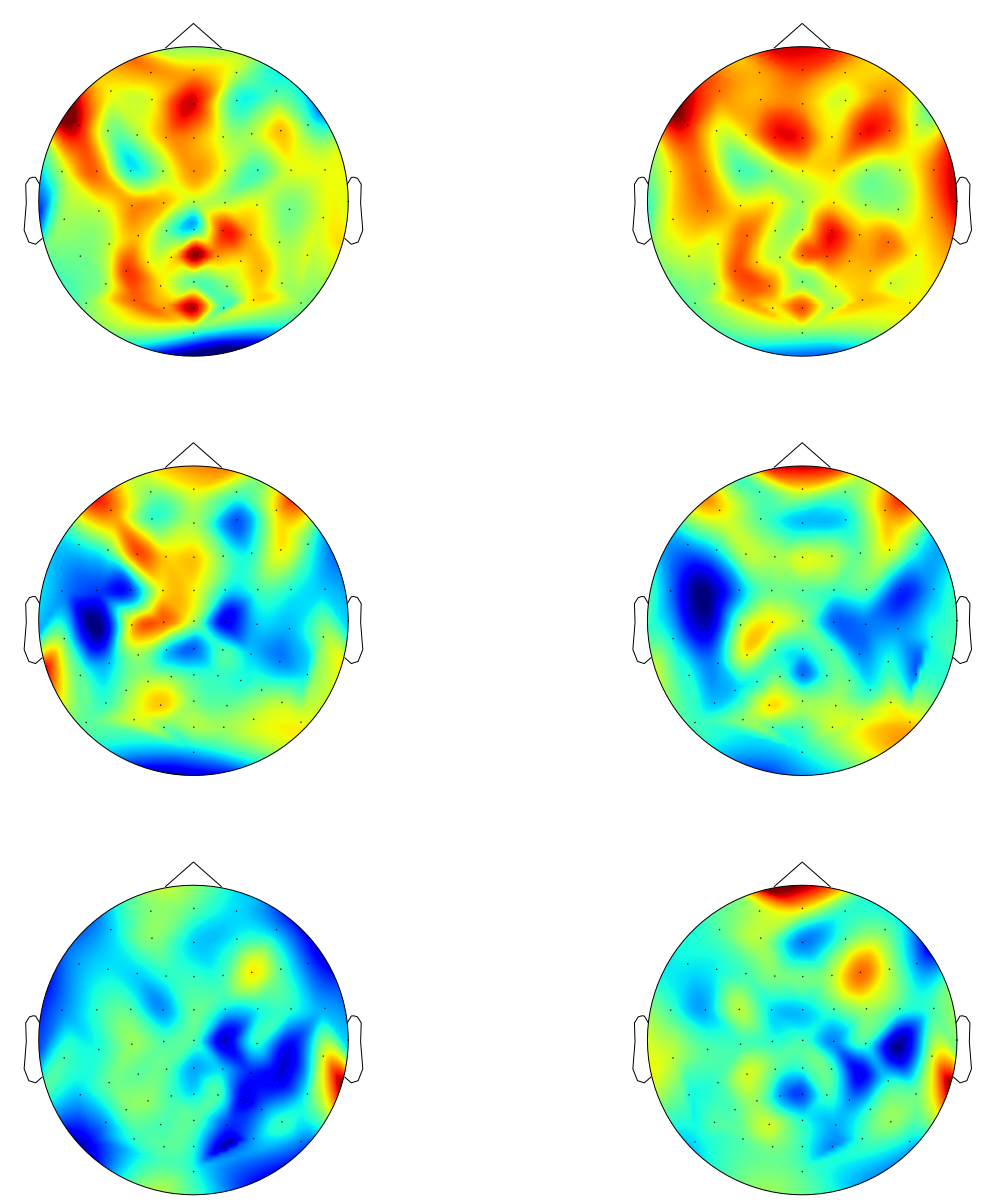

In [29]:
# graficar la conectividad luego de aplicar node strength.
f,ax = plt.subplots(len(rho_fr),len(rho_fr[0]),figsize=(20,20))
for gr in range(len(rho_fr)):
  for freq in range(len(rho_fr[gr])):
    plot_topomap(rho_fr[gr][freq], pos=info, axes=ax[gr,freq], 
                 cmap='jet',show=False,contours=0,sensors=True,
                 names=channels_names,vmin=min(min_),vmax=max(max_)) 

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa
# from mne.viz.utils import plt_show,tight_layout
# from mne.io.pick import _picks_to_idx
from scipy.spatial.distance import squareform 
# from mne.viz import plot_topomap
import matplotlib.colors as colors
import matplotlib.cm as cmx
#%% download data
FILEID = "1F9WpS7sKSFY73HSHYBgYXw9iyYalBKgh"
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id='$FILEID -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id="$FILEID -O modCSP.py && rm -rf /tmp/cookies.txt > /dev/null
#%% download data
!pip install git+https://github.com/UN-GCPDS/python-gcpds.utils.git

--2021-02-27 15:50:11--  https://docs.google.com/uc?export=download&confirm=&id=1F9WpS7sKSFY73HSHYBgYXw9iyYalBKgh
Resolving docs.google.com (docs.google.com)... 74.125.137.100, 74.125.137.113, 74.125.137.138, ...
Connecting to docs.google.com (docs.google.com)|74.125.137.100|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0k-5o-docs.googleusercontent.com/docs/securesc/mrhvkvj4t46il9p9js0uklgi704v9iqa/htvvbr50dmo3j464jlq543t63jaktq2l/1614441000000/06932581800131476027/02997255801984505350Z/1F9WpS7sKSFY73HSHYBgYXw9iyYalBKgh?e=download [following]
--2021-02-27 15:50:12--  https://doc-0k-5o-docs.googleusercontent.com/docs/securesc/mrhvkvj4t46il9p9js0uklgi704v9iqa/htvvbr50dmo3j464jlq543t63jaktq2l/1614441000000/06932581800131476027/02997255801984505350Z/1F9WpS7sKSFY73HSHYBgYXw9iyYalBKgh?e=download
Resolving doc-0k-5o-docs.googleusercontent.com (doc-0k-5o-docs.googleusercontent.com)... 74.125.137.132, 2607:f8b0:4023:c03::84
Connecting to 

In [ ]:
# import mne
from MIfunctions import *

In [ ]:
# tau =  1
# overlap=1-0.5
# ti = 4
# tf = 40
# tti = np.arange(ti,tf-tau+(tau*overlap),tau*overlap)
# ttf = np.arange(ti+tau,tf+tau*overlap,tau*overlap)
# f_frec = np.array([tti,ttf]).T

# #vtw= np.array([[0,2],[1,3],[2,4],[3,5],[4,6],[5,7]])
# tau =  2
# overlap=1-0.5
# ti = 2
# tf = 6
# tti = np.arange(ti,tf-tau+(tau*overlap),tau*overlap)
# ttf = np.arange(ti+tau,tf+tau*overlap,tau*overlap)
# vtw = np.array([tti,ttf]).T
# vtw = np.array([2.5,4.5])

In [ ]:
# creo la clase
# feat = FB_feats(fs=fs,vtw=vtw,f_frec=f_frec)
fs = 512
feat = FB_feats(fs=fs,vtw=np.array([[8,12],[12,16]]),
                f_frec=np.array([[1,1],[2,2],[3,3]]))

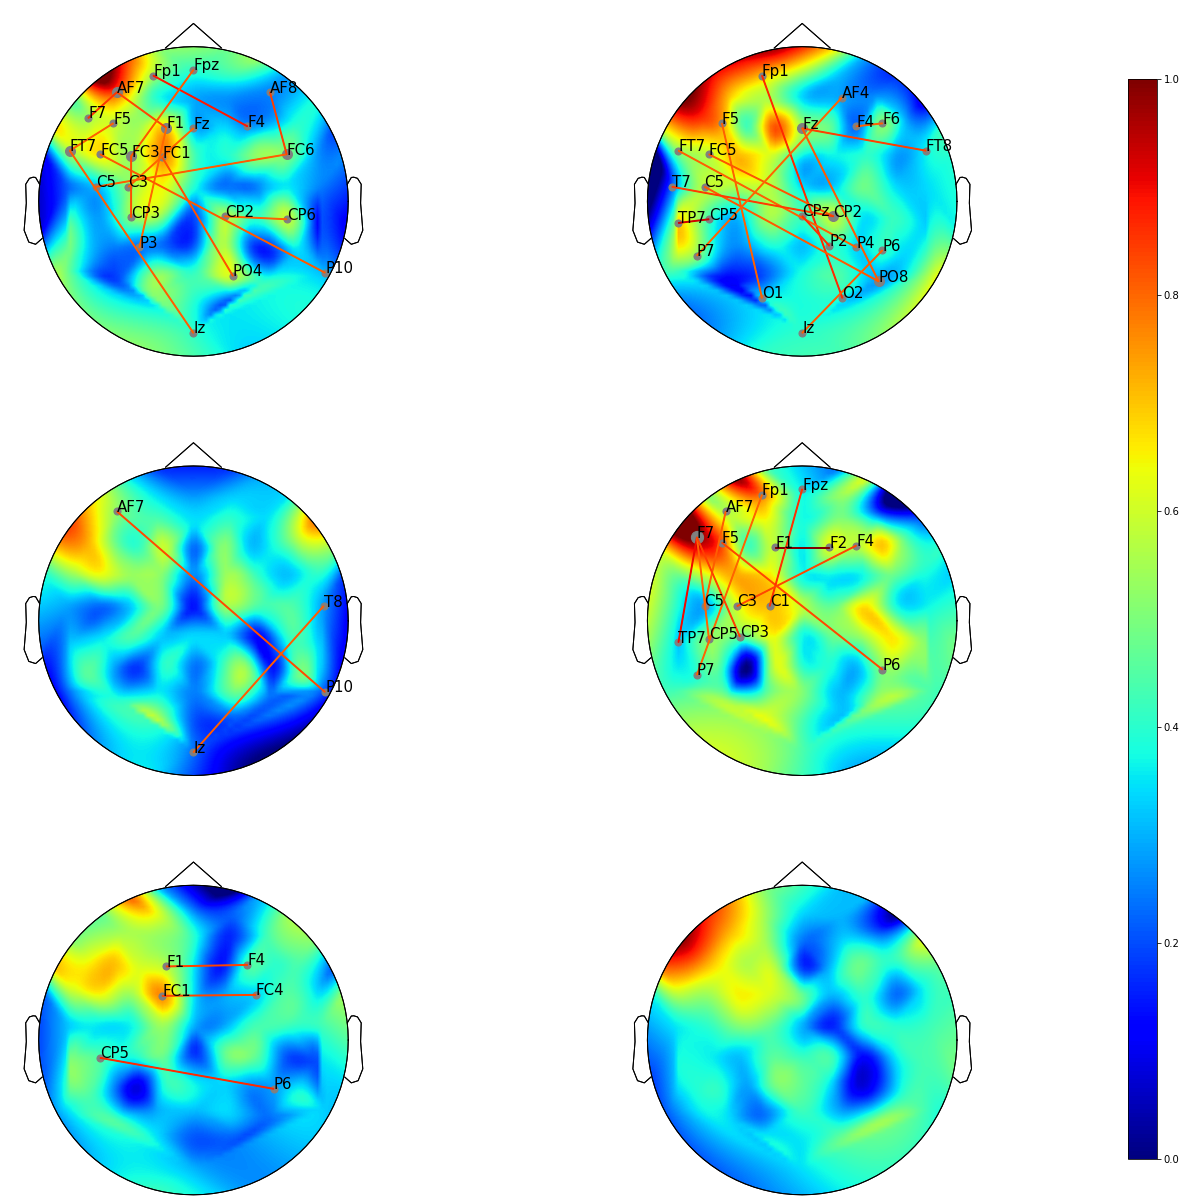

In [ ]:
# graficar los enlaces en el topoplot.
fs = 512
rho_MI = minn.fit_transform(rho_fr_.reshape(-1,1))
feat.connection_rho(rho_MI, fs, channels_names, thr=0.8, # umbral
                    figsize=(20, 20), save=True, sbj='', acc='', 
                    format='eps', path='', Ch=len(channels_names),
                    cmap_tplt='jet')